### Week 6, Part 2, Exercise 3

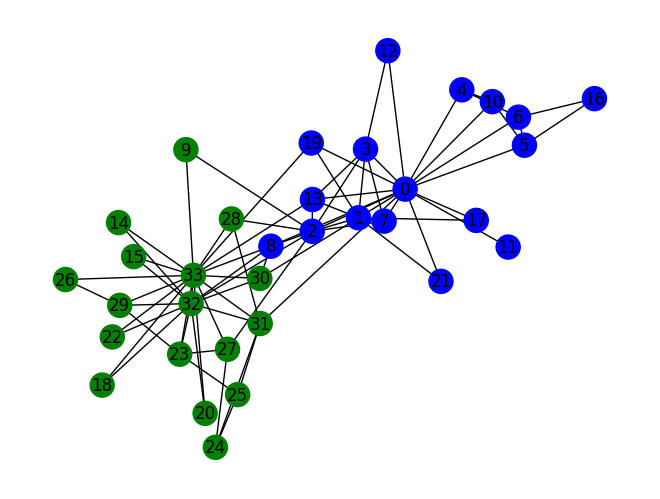

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.karate_club_graph()

club = nx.get_node_attributes(G, "club")

color_map = []
for node in G.nodes():
    if club[node] == "Mr. Hi":
        color_map.append("blue")
    else:
        color_map.append("green")

MrHiGroup = []
OfficerGroup = []
for i in range(len(color_map)):
    if club[i] == "Mr. Hi":
        MrHiGroup.append(i)
    else:
        OfficerGroup.append(i)

nx.draw(G, with_labels=True, node_color=color_map)
plt.show()


In [13]:
def modularity(G, communities):
    m = G.number_of_edges()
    q = 0.0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc/m - (kc/(2*m))**2
    return q

In [14]:
modularity(G, [OfficerGroup, MrHiGroup])

0.3582347140039447

### What is modularity

Modularity is a number that determines how well some communities (partitions) is distributed in a graph (communities). The higher the modularity, the better the communities have been split up. If the modularity is 0, then there is only 1 community. If modularity is negative, then all nodes are their own community.